In [2]:

import dataretrieval.nwis as nwis
import geopandas as gpd
from shapely.geometry import Point, box, Polygon, MultiPolygon
import requests
import pandas as pd
import datetime as dt
import earthaccess
from tqdm import tqdm
from shapely.ops import nearest_points
import sys
sys.path.append('modules/')
from retrieval_utils_appeearsTest import get_param_sites, get_all_site_granules, match_granules, get_sites_temp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import geopy
import ast

In [13]:
# set up search and call function
param_codes = ['32316'] # chla fluorescence
param_codes_str = ','.join(param_codes) 
# state_code = '06' # california
state_codes = [f"{i:02d}" for i in range(1, 57)]
site_types = ['LK', 'ES'] # lakes, estruaries
site_list = get_param_sites(param_codes_str, state_codes, site_types)

# drop missing coords
site_list['dec_lat_va'] = pd.to_numeric(site_list['dec_lat_va'], errors='coerce')
site_list['dec_long_va'] = pd.to_numeric(site_list['dec_long_va'], errors='coerce')
site_list_clean = site_list.dropna(subset=['dec_lat_va', 'dec_long_va'])

# drop bottom measurements
site_list_surf = site_list_clean[~site_list_clean['station_nm'].str.contains('bottom|deep', case=False, na=False)]

# convert headers to appeears format, save to csv
sites_df = pd.DataFrame()
sites_df['ID'] = site_list_surf['site_no'] 
sites_df['Category'] = site_list_surf['station_nm']
sites_df['Latitude'] = site_list_surf['dec_lat_va']
sites_df['Longitude'] = site_list_surf['dec_long_va']
sites_df['ID'] = sites_df['ID'].astype(str)
sites_df.to_csv(f"data/{param_codes[0]}_sites.csv", index=False)


Processing sites: 100%|█████████████████████████| 56/56 [02:13<00:00,  2.38s/it]

53


In [3]:
# import appeears data and site list 
spec_df = pd.read_csv(f"data/{param_codes[0]}_spectra.csv") 
grouped = spec_df.groupby(['Category', 'Date'])
site_list = pd.read_csv(f"data/{param_codes[0]}_sites.csv", dtype={'ID': str})
site_list.rename(columns={
    'ID': 'site_no',
    'Category': 'station_nm'
}, inplace=True)

# condense spectral data into a list of dictionaries
scenes = []
for (station_nm, date), group in grouped:
    spectral_data = group[['Band', 'wavelength', 'reflectance']].to_dict('records')
    scene = {
        'datetime': date,
        'station_nm': group['Category'].iloc[0],
        'lat': group['Latitude'].iloc[0],
        'lon': group['Longitude'].iloc[0],
        'spectra': spectral_data
    }
    scenes.append(scene)
scenes_df = pd.DataFrame(scenes)

# convert UTC to Z datetime
scenes_df['datetime'] = pd.to_datetime(scenes_df['datetime'])
scenes_df['datetime'] = scenes_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%S.000Z')

# remove text after ',' to match with appeears
def trim_station_nm(name):
    return name.split(',')[0].strip().lower()
site_list['station_nm_trimmed'] = site_list['station_nm'].apply(trim_station_nm)
scenes_df['station_nm_trimmed'] = scenes_df['station_nm'].str.strip().str.lower()
scenes_df = scenes_df.merge(
    site_list[['station_nm_trimmed', 'site_no']],
    on='station_nm_trimmed',
    how='left'
)
scenes_df.drop(columns=['station_nm_trimmed'], inplace=True)



91
                   datetime  \
0  2024-02-18T18:36:23.000Z   
1  2024-04-20T16:17:04.000Z   
2  2024-04-24T14:37:48.000Z   
3  2024-06-22T15:19:28.000Z   
4  2024-06-26T13:43:41.000Z   

                                          station_nm        lat        lon  \
0     Alum Fork Saline River at Winona Dam at Reform  34.797778 -92.845556   
1  Atlantic Oc in Deal Lk surge chmbr at Asbury P...  40.230500 -73.996750   
2  Atlantic Oc in Deal Lk surge chmbr at Asbury P...  40.230500 -73.996750   
3  Atlantic Oc in Deal Lk surge chmbr at Asbury P...  40.230500 -73.996750   
4  Atlantic Oc in Deal Lk surge chmbr at Asbury P...  40.230500 -73.996750   

                                             spectra          site_no  
0  [{'Band': 'B001', 'wavelength': 381.006, 'refl...         07362591  
1  [{'Band': 'B001', 'wavelength': 381.006, 'refl...  401350073594801  
2  [{'Band': 'B001', 'wavelength': 381.006, 'refl...  401350073594801  
3  [{'Band': 'B001', 'wavelength': 381.006, 'refl... 

In [4]:
# import mask and ensure format matches
mask_df = pd.read_csv(f"data/{param_codes[0]}_mask.csv")
mask_df.rename(columns={
    'Date': 'datetime',
    'Category': 'station_nm'
}, inplace=True)
mask_df['datetime'] = pd.to_datetime(mask_df['datetime'])
mask_df['datetime'] = mask_df['datetime'].dt.strftime('%Y-%m-%dT%H:%M:%S.000Z')
mask_df.drop(columns=['ID', 'Latitude', 'Longitude', 'elev'], inplace=True)

# merge condensed spectral data with masks
merged_df = pd.merge(scenes_df, mask_df, on=['station_nm', 'datetime'], how='left')

# filter for water and cloud
water_scenes = merged_df[merged_df['water_flag'] == 1]
visible_scenes = water_scenes[(water_scenes['cloud_flag'] == 0) & (water_scenes['cirrus_flag'] == 0)]


633
['07362591' '401350073594801' '415955111212401' '420446111183201'
 '142063398' '382847107120401' '382852107054801' '040260078'
 '415812111203901' '415941111175401' nan '385859122430101'
 '390005122441301' '385741122402101' '390046122415601' '390029122410601'
 '390021122404001' '390126122471701' '390340122490101' '390538122504901'
 '390010122401401' '01194750' '01194796' '423223070531001'
 '444306122144600' '401352074002701' '401350073595201' '401345074010601'
 '401349074000601' '401347074003501' '381142122015801' '01304057'
 '09013900' '401428105481601' '380631122032201' '390015122394801'
 '390015122395001' '390009122400201' '01208837' '01372043'
 '431314077315901' '09018500' '401030105521101' '465130091060701'
 '12300110' '295826095082200' '294643095035200' '431946118493601'
 '431946118493610' '431946118493602' '431946118493603' '431946118493604'
 '431946118493605' '431946118493606' '431946118493607' '431946118493608'
 '431946118493609' '011008745' '410757073165601' '4107290731717

In [5]:
# query the USGS database for data based on our EMIT scenes
results = match_granules(visible_scenes, param_codes)
results.to_csv(f"data/{param_codes[0]}_results.csv", index=False)

Processing scenes: 100%|██████████████████████| 633/633 [07:57<00:00,  1.33it/s]

54


In [3]:
# import results, ensure spectra is list of dicts
results = pd.read_csv(f"data/{param_codes[0]}_results.csv", dtype={'site_no': str})
results['spectra'] = results['spectra'].apply(ast.literal_eval)

# query the USGS database for temperature results, merge tables
temps = get_sites_temp(results)
results['datetime'] = pd.to_datetime(results['datetime'], utc=True)
temps['datetime'] = pd.to_datetime(temps['datetime'], utc=True)
comb_results = pd.merge(results, temps, on=['site_no', 'datetime'], how='left')


In [8]:
num_unique_sites = results['site_no'].nunique()
#print(f"Number of unique sites: {num_unique_sites}")
#print(results.head())
# Scenes per site

scenes_per_site = results['site_no'].value_counts().reset_index()
scenes_per_site.columns = ['site_no', 'scene_count']
print(scenes_per_site)

site_no_plot = '380631122032201' 
site_scenes = results[results['site_no'] == site_no_plot]
#print(site_scenes)

            site_no  scene_count
0   380631122032201           11
1          11455508           10
2   295826095082200            9
3         011008745            6
4          04236000            4
5   294643095035200            3
6          01304650            3
7          01303152            3
8   444306122144600            1
9   381142122015801            1
10         01304057            1
11  374938122251801            1
12  431533076582101            1


In [9]:
spectra_expanded = site_scenes.explode('spectra').reset_index(drop=True)

spectra_expanded['wavelength'] = spectra_expanded['spectra'].apply(lambda x: x['wavelength'])
spectra_expanded['reflectance'] = spectra_expanded['spectra'].apply(lambda x: x['reflectance'])
# Use datetime as scene identifier

spectra_expanded.drop(columns=['spectra', 'lat', 'lon', 'site_no'], inplace=True)
#spectra_expanded.drop(columns=['spectra', 'lat', 'lon', 'result_time', 'result_unit', 'site_no'], inplace=True)

print(spectra_expanded)
# Reset index for good measure
spectra_expanded.reset_index(drop=True, inplace=True)


                                  station_nm                  datetime  \
0     GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2023-05-27 22:53:15+00:00   
1     GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2023-05-27 22:53:15+00:00   
2     GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2023-05-27 22:53:15+00:00   
3     GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2023-05-27 22:53:15+00:00   
4     GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2023-05-27 22:53:15+00:00   
...                                      ...                       ...   
3130  GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2024-09-26 21:39:56+00:00   
3131  GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2024-09-26 21:39:56+00:00   
3132  GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2024-09-26 21:39:56+00:00   
3133  GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2024-09-26 21:39:56+00:00   
3134  GRIZZLY BAY A SUISUN SLOUGH NR AVON CA 2024-09-26 21:39:56+00:00   

      result result_unit                    result_time  wavelength  \
0        7.8        ug/l  2023-05-27T15:

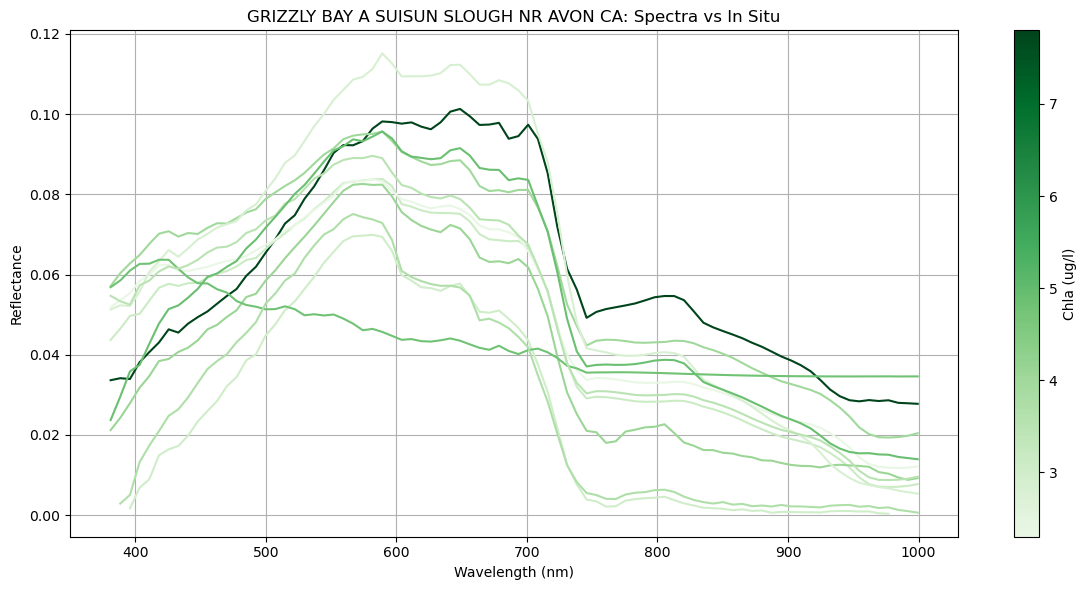

In [11]:
# Remove fill and negative values
spectra_expanded['reflectance'] = spectra_expanded['reflectance'].replace(-9999, np.nan)
spectra_expanded['reflectance'] = spectra_expanded['reflectance'].where(abs(spectra_expanded['reflectance'] - (-0.01)) > 1e-8, np.nan)
spectra_expanded['reflectance'] = spectra_expanded['reflectance'].where(spectra_expanded['reflectance'] >= 0, np.nan)
spectra_expanded = spectra_expanded[spectra_expanded['wavelength'] <= 1000]

norm = mcolors.Normalize(vmin=spectra_expanded['result'].min(), vmax=spectra_expanded['result'].max())
cmap = cm.Blues
cmap = cm.Greens
cmap = cmap(np.linspace(0.1, 1, cmap.N))
cmap = mcolors.ListedColormap(cmap)

plt.figure(figsize=(12, 6))

for datetime, group in spectra_expanded.groupby('datetime'):
    result_label = group['result'].iloc[0]
    color = cmap(norm(result_label))
    plt.plot(group['wavelength'], group['reflectance'], color=color)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title(f"{spectra_expanded['station_nm'].iloc[0]}: Spectra vs In Situ")
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=plt.gca(), label='Chla (ug/l)', orientation='vertical')
plt.grid(True)
plt.tight_layout()
plt.show()



In [1]:

unique_sites = results['site_no'].drop_duplicates().head(20)
filtered_scenes = results[results['site_no'].isin(unique_sites)]

# Select the first scene for each unique site
first_scenes = filtered_scenes.groupby('site_no').first().reset_index()

# Exploding the 'spectra' list into separate rows and creating a DataFrame for plotting
spectra_list = []
for index, row in first_scenes.iterrows():
    for spectrum in row['spectra']:
        spectra_list.append({
            'datetime': row['datetime'],
            'site_no': row['site_no'],
            'wavelength': spectrum['wavelength'],
            'reflectance': spectrum['reflectance']
        })

spectra_df = pd.DataFrame(spectra_list)
spectra_df['reflectance'] = spectra_df['reflectance'].replace(-9999, np.nan)
spectra_df['reflectance'] = spectra_df['reflectance'].where(spectra_df['reflectance'] >= 0, np.nan)

# Plotting the spectra
plt.figure(figsize=(15, 8))
for site_no, group in spectra_df.groupby('site_no'):
    plt.plot(group['wavelength'], group['reflectance'], label=f'Site {site_no}')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Representative Spectral Reflectance for Selected Sites')
plt.legend(title='Site Number', loc='upper right')
plt.grid(True)
plt.show()


NameError: name 'results' is not defined